In [3]:
import datetime
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib as plt

In [31]:
# dataset_path = os.path.abspath(r'C:\DevEnv\Workspaces\facemask-maker\datasets\ds5_fake_face_mask')
dataset_path = os.path.abspath(r'C:\DevEnv\Workspaces\facemask-maker\datasets\ds7_medical_mask_classes\cropped')
model_save_path = os.path.abspath(r'fmd_mobile_2.model')
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
SHAPE = (224, 224, 3)
ACC_THRESHOLD = 0.99

In [5]:
# set test and train datasets using ImageDataGenerator

image_data_generator = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest",
	preprocessing_function=preprocess_input,
	validation_split=0.2

)

train_data_generator = image_data_generator.flow_from_directory(
	dataset_path,
	target_size=SHAPE[:2],
	batch_size=BS,
	class_mode='categorical',
	subset='training'
)

test_data_generator = image_data_generator.flow_from_directory(
	dataset_path,
	target_size=SHAPE[:2],
	batch_size=BS,
	class_mode='categorical',
	subset='validation'
)

Found 4600 images belonging to 2 classes.
Found 1149 images belonging to 2 classes.


In [6]:
# set model

print('[INFO] compiling model...')

baseModel = MobileNetV2(weights="imagenet",
						include_top=False,
						input_tensor=Input(shape=SHAPE))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print('[INFO] model was compiled successfully')

[INFO] compiling model...
[INFO] model was compiled successfully


In [15]:
STEP_SIZE_TRAIN=train_data_generator.n//train_data_generator.batch_size
STEP_SIZE_VALID=test_data_generator.n//test_data_generator.batch_size
STEP_SIZE_TEST=test_data_generator.n//test_data_generator.batch_size

class myCallback(Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('accuracy') > ACC_THRESHOLD:
			print(f"\nReached %{ACC_THRESHOLD*100} accuracy, so stopping training")
			self.model.stop_training = True

In [10]:
print("[INFO] start of training head...")
start_time = time.time()

H = model.fit(
	train_data_generator,
	steps_per_epoch=len(train_data_generator),
	validation_data=test_data_generator,
	validation_steps=len(test_data_generator),
	epochs=EPOCHS,
	callbacks=[myCallback()]
)

end_time = time.time()
print("[INFO] training was finished successfully")
print(f'[INFO] training time: {str(datetime.timedelta(seconds=end_time-start_time))}')


[INFO] start of training head...
Epoch 1/20
144/144 [==============================] - 94s 649ms/step - loss: 0.1974 - accuracy: 0.9202 - val_loss: 0.2970 - val_accuracy: 0.8695

In [30]:
print("[INFO] evaluating network...")
predictions = model.predict_generator(test_data_generator, steps=STEP_SIZE_VALID, verbose=1)
y_predictions = np.argmax(predictions, axis=-1)
print(classification_report(test_data_generator.classes[:len(y_predictions)], y_predictions, target_names=test_data_generator.class_indices))

[INFO] evaluating network...
35/35 [==============================] - 19s 541ms/step

In [32]:
print("[INFO] saving mask detector model...")
model.save(model_save_path, save_format="h5")

[INFO] saving mask detector model...


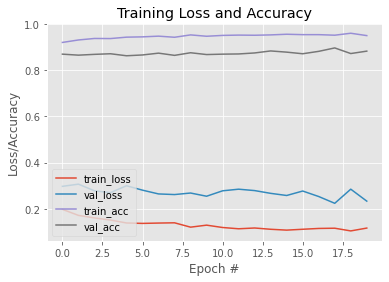

In [33]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
# plt.savefig(args["plot"])